Have you ever stood still, contemplating about how cool would it be to build a model that can distinguish cats from dogs? Don't be shy now! Of course you did! Let's get going!

# Cat or a dog?

We have 25,000 labeled pictures of dogs and cats. The data comes from Kaggle's [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) challenge. That's how a bunch of them look like:

<img src="https://static1.squarespace.com/static/54856bade4b0c4cdfb17e3c0/t/57edead437c581d6fb8a2e98/1475209950357?format=1500w"/>

Let's focus on a specific image. Each picture can be represented as a 3-dimensional array. We will resize all training image to $50 \times 50$ pixels. Here's a crazy example:

<img src="https://static1.squarespace.com/static/54856bade4b0c4cdfb17e3c0/t/57edf15c9f74563967b893a2/1475211614805?format=1500w"/>

Additionally, we will remove all color and turn them pictures into grayscale ones. First things first, let's prepare our environment:

# Setting up

In [1]:
import cv2
import numpy as np
import os         
from random import shuffle 
from tqdm import tqdm      
import tensorflow as tf
import matplotlib.pyplot as plt

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

%matplotlib inline

TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogs-vs-cats-convnet'

In [2]:
tf.__version__

'1.1.0'

# Image preprocessing

We have 25,000 images for training and 12,500 for testing. Let's create a function that encodes the labels of the training images: 

In [3]:
def create_label(image_name):
    """ Create an one-hot encoded vector from image name """
    word_label = image_name.split('.')[-3]
    if word_label == 'cat':
        return np.array([1,0])
    elif word_label == 'dog':
        return np.array([0,1])

Now, for the actual reading of training and test data. Every image will be resized to $50 \times 50$ pixels and read as grayscale:

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img_data), create_label(img)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [5]:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img_data), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

Now, let's split the data. 24,500 images for training and 500 for testing. We also need to reshape the data appropriately for TensorFlow:

In [6]:
# If dataset is not created:
train_data = create_train_data()
test_data = create_test_data()

# If you have already created the dataset:
# train_data = np.load('train_data.npy')
# test_data = np.load('test_data.npy')

train = train_data[:-500]
test = train_data[-500:]

X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]

100%|██████████| 12500/12500 [00:32<00:00, 387.32it/s]


# Convolutional Neural Nets

How will we do it? Isn't that just too hard of a task? Convolutional Neural Networks to the rescue!

In the past, people had to think of and code different kinds of features that might be relevant to the task at hand. Examples of that would be whiskers, ears, tails, legs, fur type detectors. These days, we can just use Convolutional NNs. They can learn features from raw data. How do they work?

<div class="center">
    <iframe width="100%" height="360" src="https://www.youtube.com/embed/FmpDIaiMIeA" frameborder="0" allowfullscreen></iframe>
</div>

Ok, got it? It was a great explanation. You can think of convolutions as small sliding lenses (let's say a $5 \times 5$) that are "activated" when are placed above some feature that is familiar to them. That  way, convolutions can make sense of larger portions of the image, not just single pixels.

# Building our model

Finally, the fun part begins! We will use [tflearn](http://tflearn.org/) to build our Convolutional Neural Network. One additional bonus will be the use of a *Dropout* layer. Here's the model:

In [7]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)

model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 11.45499 | time: 35.818s
| Adam | epoch: 010 | loss: 11.45499 - acc: 0.5025 -- iter: 24448/24500
Training Step: 3830  | total loss: 11.49676 | time: 36.938s
| Adam | epoch: 010 | loss: 11.49676 - acc: 0.5007 | val_loss: 11.60503 - val_acc: 0.4960 -- iter: 24500/24500
--


We resized our images to $50 \times 50 \times 1$ matrices and that is the size of the input we are using.

Next, a **convolutional** layer with 32 filters and stride = 5 is created. The activation function is ReLU. Right after that, a **max pool** layer is added. That same trickery is repeated again with 64 filters.

Next, a **fully-connected** layer with 1024 neurons is added. Finally, a **dropout** layer with keep probability of 0.8 is used to finish our model.

We use **Adam** as optimizer with learning rate set to 0.001. Our loss function is **categorical cross entropy**. Finally, we train our Deep Neural Net for 10 epochs.

All that is great, but our validation accuracy doesn't seem that good. Flipping a coin might be a better model than the one we created. Let's go bigger and better (hopefully):

# Building our (bigger) model

In [8]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)

model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.34434 | time: 44.501s
| Adam | epoch: 010 | loss: 0.34434 - acc: 0.8466 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.35046 | time: 45.619s
| Adam | epoch: 010 | loss: 0.35046 - acc: 0.8432 | val_loss: 0.50006 - val_acc: 0.7860 -- iter: 24500/24500
--


That is pretty much the same model. One difference is the number of convolutional and max pool layers we added. So, our model has much more parameters and can learn more complex functions. One proof of that is the validation accuracy that is around 0.8. Let's take our model for a spin!

# Did we do well?

Let's have a look at a single prediction:

cat: 0.8773844838142395, dog: 0.12261549383401871


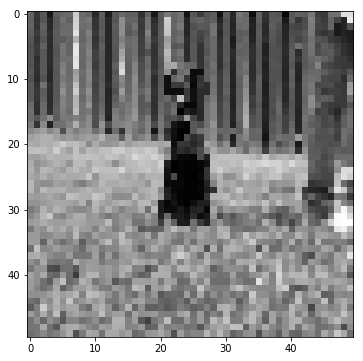

In [21]:
d = test_data[0]
img_data, img_num = d

data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
prediction = model.predict([data])[0]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap="gray")
print(f"cat: {prediction[0]}, dog: {prediction[1]}")

That doesn't look right. How about some more predictions:

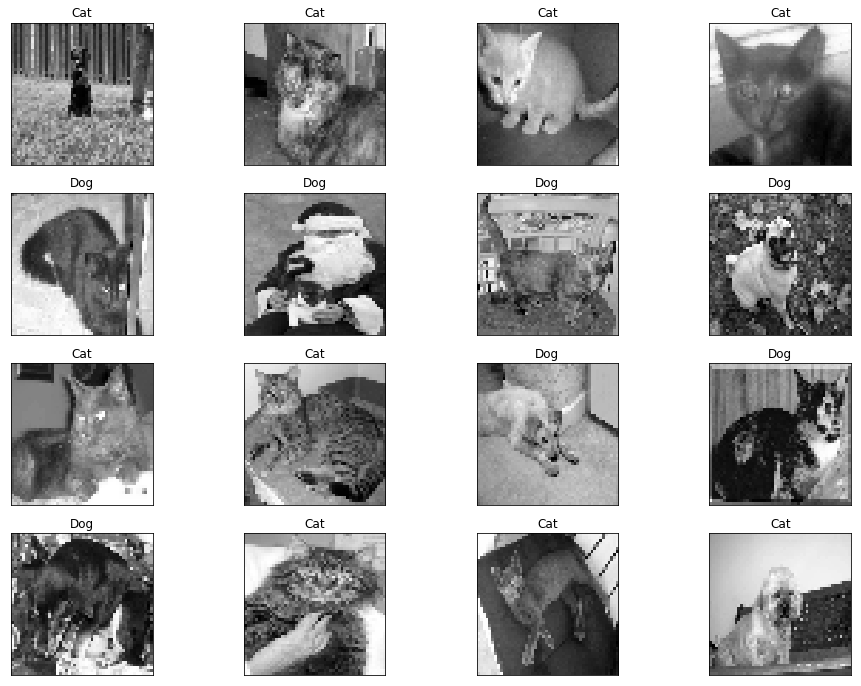

In [10]:
fig=plt.figure(figsize=(16, 12))

for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

# Conclusion

There you have it! Santa is a dog! More importantly, you built a model that can distinguish cats from dogs using only raw pixels (albeit, with a tiny bit of preprocessing). Additionally, it trains pretty fast on relatively old machines! Can you improve the model? Maybe change the architecture, keep probability parameter of the Dropout layer or the optimizer? What results did you get?

The only thing left for you to do is snap a photo of your cat or dog and run it through your model. Was the net correct?

# References

[An Intuitive Explanation of Convolutional Neural Networks](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)<br/>
[CS231n - Convolutional Neural Networks (CNNs / ConvNets)](https://cs231n.github.io/convolutional-networks/)<br/>
[Cats and dogs and convolutional neural networks](http://www.subsubroutine.com/sub-subroutine/2016/9/30/cats-and-dogs-and-convolutional-neural-networks)<br/>
[Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)